In [13]:
import ptychoSampling.farfield.run_methods.utils as utils 
import ptychoSampling.farfield.analysis_scripts.analysis_utils as anut
import ptychoSampling.farfield.analysis_scripts.combined_analysis_utils as cbut
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import ptychoSampling.farfield.analysis_scripts.latex_output_utils as ltxut
from ptychoSampling.farfield.analysis_scripts.lines_keys import colors, markers, linestyles
import ptychoSampling.farfield.analysis_scripts.plot_params as params
from ptychoSampling.farfield.analysis_scripts.plot_utils import xy, getData, PlotData, _plotObjAmpl, _plotObjPhase
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import dill
import string

In [2]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Whether to reload existing simulation data (if available) or to create new data

sim_items = utils.getSimulationAndGuesses(reload_simulation=True, 
                                          default_path_str='/raid/home/skandel/code/ptychoSampling_v2/experiments/farfield/noiseless/')
#background_level = 1e-8
#sim_items['intensities'] = sim_items['intensities'] + background_level

Loaded successfully


In [5]:
location = 'poisson_1e3'
base_path = f'/raid/home/skandel/code/ptychoSampling_v2/experiments/farfield/{location}'
#data_paths = [f'{p}/figures/' for p in base_paths]

In [8]:
subplot_titles = {(0,0): 'Probe mag.', (0,1): 'Object mag.', #(0,2): 'SPR phase, Gaussian', (0,3): 'BPR phase, Gaussian', 
                  (1,0): 'Probe phase', (1,1): 'Object phase'}#, (1,2): 'SPR phase, Poisson', (1,3): 'BPR phase, Poisson'}

-1.5707963 1.5707964


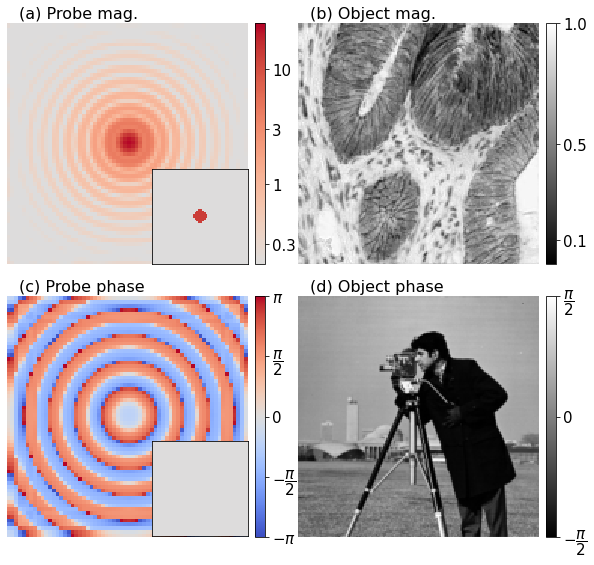

In [24]:
fig, axes = plt.subplots(2, 2, figsize=[8, 7.5], constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.text(0.05, 1.02, '(' + string.ascii_lowercase[i] + ') ' + list(subplot_titles.values())[i],
            transform=ax.transAxes, size=16)

probe_absvals = np.abs(sim_items['probe'].wavefront.fftshift)
probe_angvals = np.angle(sim_items['probe'].wavefront.fftshift)

probe_absvals[probe_absvals<0.2] = 0.2

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

#plt.sca(axes[0,0])
im = axes[0,0].pcolormesh(probe_absvals, cmap=new_cmap, norm=LogNorm(vmin=0.2, vmax=25))

divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[0.1, 0.3, 1, 3, 10, 30])
cb.ax.set_yticklabels([0.1, 0.3, 1, 3, 10, 30])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)


#cb = plt.colorbar(im, ax=axes[0,0], ticks=[0.1, 0.3, 1, 3, 10, 30], pad=0., aspect=30)#, shrink=0.9, aspect=50)
#cb.ax.minorticks_off()
#cb.ax.set_yticklabels([0.1, 0.3, 1, 3, 10, 30])
#cb.ax.tick_params(labelsize=15)

# Inset with probe guess

axin = axes[0,0].inset_axes([0.6, 0.0, 0.4, 0.4])
guess_probe_absvals = np.abs(sim_items['default_probe_guess'].wavefront.fftshift)
guess_probe_angvals = np.angle(sim_items['default_probe_guess'].wavefront.fftshift)

guess_probe_absvals[guess_probe_absvals<0.2] = 0.2

#axin.set_axis_off()

caxin = axin.pcolormesh(guess_probe_absvals, cmap=new_cmap,
                        norm=LogNorm(vmin=0.2, vmax=25))
#caxin.axes.set_axis_off()
axin.set_aspect('equal')
axin.set_xticks([])
axin.set_yticks([])

# Probe phase
axes[1,0].set_axis_off()
axes[1,0].set_aspect('equal')

im = axes[1,0].pcolormesh(probe_angvals, cmap='coolwarm',
                           norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.minorticks_off()
cb.ax.set_yticklabels([r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$', r'$\pi$'])
cb.ax.tick_params(labelsize=15)

axin = axes[1,0].inset_axes([0.6, 0, 0.4, 0.4])
caxin = axin.pcolormesh(guess_probe_angvals, cmap='coolwarm',
                       norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))
#cax.axes.set_axis_off()
#caxin.axes.set_axis_off()
axin.set_aspect('equal')
axin.set_xticks([])
axin.set_yticks([])

# Object mags and phase
obj_absvals = np.abs(sim_items['obj'].array)
obj_angvals = np.angle(sim_items['obj'].array)
diff = np.max(obj_angvals) - np.pi / 2
obj_angvals = obj_angvals - diff


maxval = np.max([0, obj_absvals.max()])
im = axes[0,1].pcolormesh(obj_absvals, cmap='gray', vmin=0, vmax=maxval)
divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[0.1, 0.5, 1.0])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)

print(obj_angvals.min(), obj_angvals.max())
im = axes[1,1].pcolormesh(obj_angvals, cmap='gray', vmin=-np.pi/2, vmax=np.pi/2)
#cax.axes.set_axis_off()
#cb = plt.colorbar(im, ax=axes[1,1], ticks=[-np.pi/2, 0, np.pi/2], pad=0., shrink=0.9, aspect=70)
#cb.ax.minorticks_off()
divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi/2, 0, np.pi/2])

cb.ax.set_yticklabels([r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$'])
cb.ax.tick_params(labelsize=15)

plt.savefig('probe_obj_phase.pdf', bbox_inches='tight')

plt.show()

In [238]:
guess_probe_absvals.max()

Wavefront(13.245323, dtype=float32)